In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math
import cv2
from scipy import misc
import math
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage


original_image = mpimg.imread('Image.jpg')
plt.imshow(original_image)
print(original_image.shape)

(420, 560)


## Median Filtering

In [2]:
def add_salt_pepper_noise(percentage, image):
    corrupted_image = image.copy()
    total_times = int(image.shape[0] * image.shape[1] * percentage // 100)
    for _ in range(total_times):
        x = random.randint(0, image.shape[1]-1)
        y = random.randint(0, image.shape[0]-1)
        corrupted_image[y, x] = random.choice([0, 255])
    return corrupted_image

In [3]:
def _median_filter_(img, m_filter_s):
    result = []
    padding_size = m_filter_s[0]//2
    padded_img = np.pad(img, (padding_size, padding_size), 'constant', constant_values=(0,0))
    for r in range(padded_img.shape[0]-int(np.ceil(m_filter_s[0]/2))):
        row = []
        for c in range(padded_img.shape[1]-int(np.ceil(m_filter_s[0]/2))):
            curr_region = padded_img[0+r:r+m_filter_s[0]:1,0+c:c+m_filter_s[1]:1]
            #print("region : ", curr_region)
            curr_result = np.median(curr_region)
            row.append(curr_result)
        result.append(np.array(row))
    final_result = np.array(result)
    return final_result

def median_filtering(corrupted_image, size):
    if len(corrupted_image.shape) != 2 and len(size) != 2:
        print("Error: Image and Filter should be greyscale or 2D matrix")
        sys.exit()
    if (size[0] != size[1]):
        print('Error: Filter must be a square matrix')
        sys.exit()
    filtered_image = _median_filter_(corrupted_image, size)
    return filtered_image

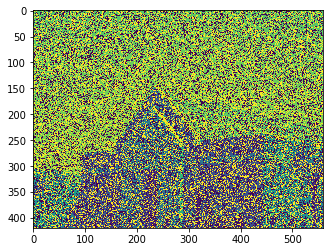

In [5]:
corrupted_image = add_salt_pepper_noise(70, original_image)
plt.imshow(corrupted_image)

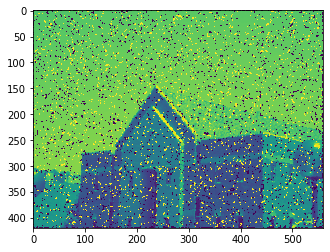

In [6]:
median_filtered = median_filtering(corrupted_image, [3, 3])
plt.imshow(median_filtered)

## Hough Transform

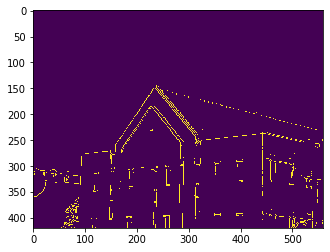

In [7]:
canny_edges = cv2.Canny(original_image,200,200)
plt.imshow(canny_edges)

### Hough Space

In [8]:
def calculate_hough_space(image):
    image_shape = image.shape
    x_max = image_shape[0]
    y_max = image_shape[1]
    
    theta_max = 1.0 * math.pi 
    theta_min = 0.0

    r_min = 0.0
    r_max = math.hypot(x_max, y_max)
    
    r_dim = 200
    theta_dim = 360

    hough_space = np.zeros((r_dim,theta_dim))

    for x in range(x_max):
        for y in range(y_max):
            if image[x,y] == 255:
                for itheta in range(theta_dim):
                    theta = (1.0 * itheta) * theta_max / theta_dim
                    r = x * math.cos(theta) + y * math.sin(theta)
                    ir = ( 1.0 * r ) * r_dim / r_max
                    hough_space[int(ir),int(itheta)] += 1
    
    neighborhood_size = 20
    threshold = 140

    data_max = filters.maximum_filter(hough_space, neighborhood_size)
    maxima = (hough_space == data_max)

    data_min = filters.minimum_filter(hough_space, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)

    theta, r = [], []
    for dr,dtheta in slices:
        theta_center = (dtheta.start + dtheta.stop - 1)/2
        theta.append(theta_center)
        r_center = (dr.start + dr.stop - 1)/2    
        r.append(r_center)
    scaling_factors = (r_max, r_dim, theta_max, theta_dim)
    return hough_space, r, theta, scaling_factors


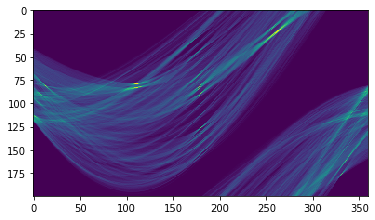

In [9]:
hough_space, rs, thetas, scaling_factors = calculate_hough_space(canny_edges)
plt.imshow(hough_space)

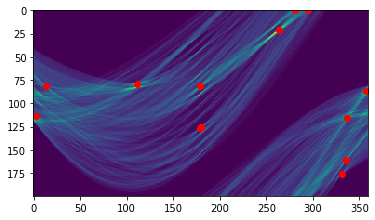

In [11]:
plt.imshow(hough_space)
plt.autoscale(False)
plt.plot(thetas,rs, 'ro')

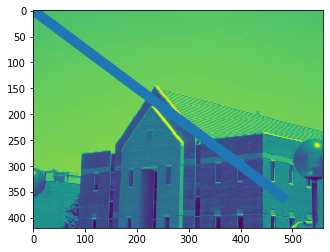

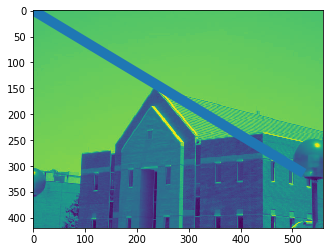

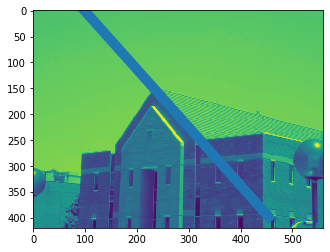

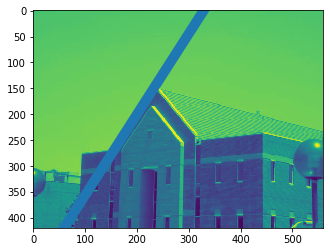

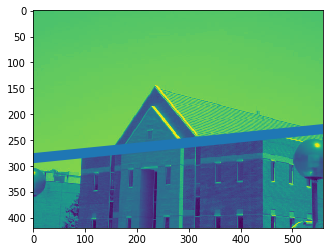

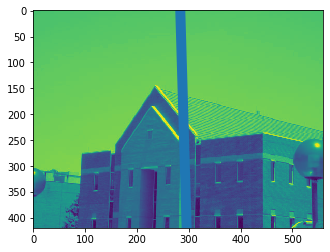

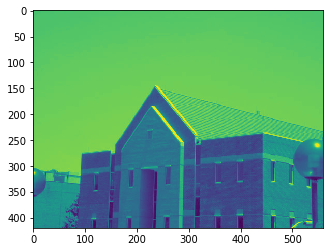

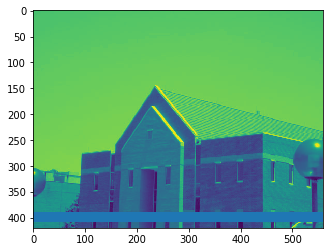

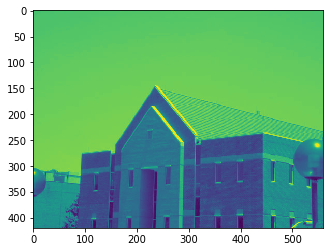

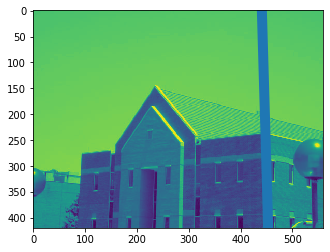

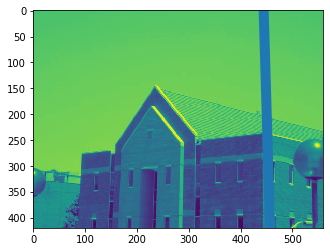

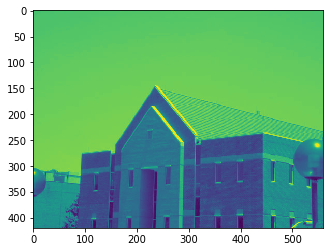

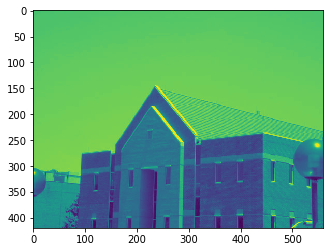

In [12]:
r_max, r_dim, theta_max, theta_dim = scaling_factors
x_max = int(original_image.shape[0])
y_max = int(original_image.shape[1])

line_index = 1

for i,j in zip(rs, thetas):

    r = round( (1.0 * i * r_max ) / r_dim,1)
    theta = round( (1.0 * j * theta_max) / theta_dim,1)

    fig, ax = plt.subplots()

    ax.imshow(original_image)

    ax.autoscale(False)

    px = []
    py = []
    for i in range(-y_max-40,y_max+40,1):
        px.append( math.cos(-theta) * i - math.sin(-theta) * r ) 
        py.append( math.sin(-theta) * i + math.cos(-theta) * r )

    ax.plot(px,py, linewidth=10)
    line_index = line_index + 1
plt.show()